<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW6/HW6_JBoecher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline




Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

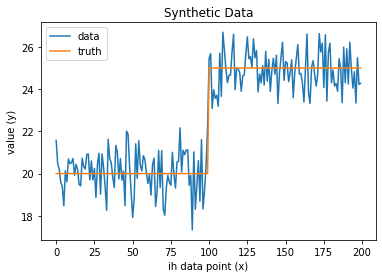

In [106]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data") 
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("ih data point (x)")
pl.ylabel("value (y)")
pl.title("Synthetic Data")
pl.legend();

**Fig. 1.** Randomly generated data drawn from normal distributions. The first half of the data has mean = 20 and the second half has mean = 25. The blue line represent the generated data points, while the orange line plots the known mean of the distributions. The data points x = 0 through x = 99 are centered around 20, while the data points x = 100 through x = 199 are centered around 25. Becasue two sub-datasets have been concatenated to form this dataset, it is known that there is a point of change at x = 100.

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [107]:
def maxdiff(y):
    """calculates the POC as the points that maximizes the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
    
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(ym[i:]) -  f(ym[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 20.09, mean after: 24.89


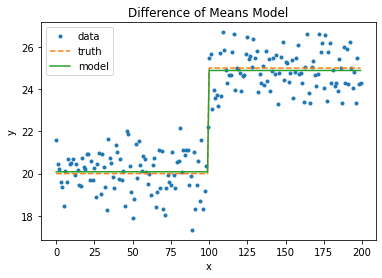

In [112]:
poc, before, after = maxdiff(ym)   
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.title("Difference of Means Model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Fig. 2.** The plot shows the same data as fig. 1. The datapoints are represented as blue dots. The dashed orange line represents the thruth/the true mean which is known to be 20 and 25, respectively (because we generated the datasets that way) and the green line represents the mean that was actually obtained by drawing 100 random numbers of standard normal distributions with mean 20 and 25, respectively. 

The lines differ slightly, because the data points do not have the exact mean of 20 or 25 due to stochasticity. 

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa22_6#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [109]:
def mse(y):
  """ calculates the mean squared error at each point
  """
  N = len(y)
  sq_errors = []
  f = np.nanmean
  for i in range(0, N):
    sq_errors.append((y[i] - f(y[i:]))**2)
  mse = sum(sq_errors)/N
  return mse

def poc_mse(y):
  """calculates the POC as the point that minimizes the squared error
    y: vector of endogenouos variables
  """
  N = len(y)
  f = np.nanmean
  mse_all = mse(y)
  poc, before, after = 0, np.nan, np.nan
  for i in range(1, N):
    mse_before = mse(y[:i])
    mse_after = mse(y[i:])
    mse_sum = mse_before + mse_after
    if mse_all > mse_sum:
      mse_all = mse_sum
      poc = i
      before, after = f(y[:i]), f(y[i:])
  return (poc, before, after)
    

In [110]:

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))


poc: 100.00, mean before: 20.09, mean after: 24.89


**Comment:** The MSE method yields the same result as the maxdiff function and matches our expectations based on the characteristics we chose when generating the data. This validates the function. 

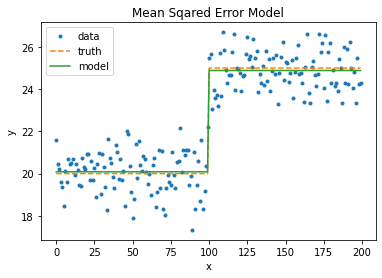

In [113]:
poc, before, after = poc_mse(ym)   
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.title("Mean Sqared Error Model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Fig. 3.** The plot shows the same data as fig. 1 and 2. The datapoints are represented as blue dots. The dashed orange line represents the thruth/the true mean which is known to be 20 and 25, respectively (because we generated the datasets that way) and the green line represents the mean that was actually obtained by drawing 100 random numbers of standard normal distributions with mean 20 and 25, respectively.

The lines differ slightly, because the data points do not have the exact mean of 20 or 25 due to stochasticity.

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [119]:
mu1, mu2 = 20, 25
s1 = 1
s2 = 4
ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])

In [120]:
def maxdiff(y, sigma=False):
    """calculates the POC as the points that maximized the difference between 
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables 
    sigma: finds the POC that maximizes the difference between before/after POC variance 
                (optional, default is before/after mean)
    """
    N = len(y)
    f = np.nanmean
    v = np.nanvar
    poc, var, before, after = 0, 0, np.nan, np.nan 
    for i in range(1, N):
            var_here = np.abs(v(ys[i:]) - v(ys[:i])) #var1 - var2
            if var < var_here:
                var = var_here
                poc = i
                before, after = np.sqrt(v(ys[:i])), np.sqrt(v(ys[i:]))
    return(poc, before, after)  


print("poc: {:.2f}, standard deviation before: {:.2f}, standard deviation after: {:.2f}".format(*maxdiff(ys, 
                                                                    sigma=True)))

poc: 101.00, standard deviation before: 0.99, standard deviation after: 3.68


**Comment:** This model differs from the previous models in that it considers the variance of the dataset to deermine a change point. The function returns std = 0.99 and std = 3.68, which is close to the standard deviations we specified when generated the new datatset (1 and 4). The PoC is at x = 101, where we expect the differece in variance to begin.

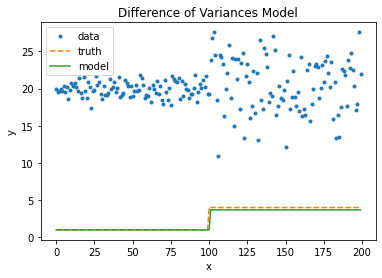

In [121]:
poc, before, after = maxdiff(ys, sigma = True)   
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [s1] * 100 + [s2] *100, '--', label = 'truth')
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.title("Difference of Variances Model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Fig. 4.** This plot shows randomly generated data that was drawn from a normal distribution with mean 20. The first half of the series has standard deviation appr. = 1 (0.99) and the second half has standard deviation appr. = 4 (3.68).

The datapoints are represented as blue dots. The dashed orange line represents the thruth/the true standard deviation which is known to be 1 and 4, respectively (because we generated the datasets that way) and the green line represents the standard deviation that was actually obtained by drawing 100 random numbers from normal distributions with std 1 and 4, respectively.

The lines differ slightly, because the data points do not have the exact standard deviations of 1 and 4 due to stochasticity.

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

In [17]:
#!pip install ruptures

In [18]:
#import ruptures as rpt
#import pandas as pd
#import matplotlib as plt

**Comment:** Imports moved to top. 

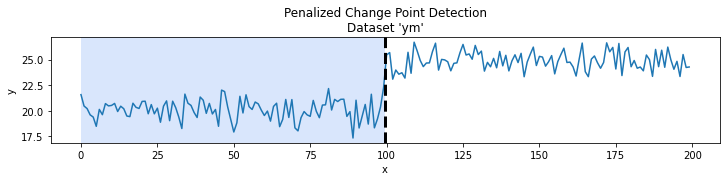

In [149]:
# detection
algo = rpt.Pelt(model="rbf").fit(ym)
result = algo.predict(pen = 1)

# display
rpt.display(ym, [100], result)
pl.title("Penalized Change Point Detection\nDataset 'ym'")
pl.xlabel("x")
pl.ylabel("y")
pl.show()

**Fig. 5.** Change point detection using the rupture package. The breakpoint is correctly placed at ~ x = 100. The code is run on the ym dataset that was randomly generated and manipulated in terms of mean. The pelt method was used and pen was set = 1. 

Pen denotes the penalty value (e.g., how sensitive is my model to deviations). It must be > 0, but doesn't have to be an integer. The larger the penalty value, the fwer breakpoints will be detected. Here, I used trial and error to find the pen setting that would return a single breakpoint. I think an elbow plot method should be used to do it properly.

**Comment:** Pelt stands for Penalized change point detection, a method that computes segmentation by minimizing the constrained sum of approximation errors. 

The cost function is chosen by the user and specified using "model". I chose "rbf" (radial distance function) here.

The model is then fit onto the signal using the method .fit(). 

.predict() performs the change point detection using the algorithm specified above. It outputs a list of breakpoints (last entry is the # datapoints).

"Pen" allows the user to specify the penalty value. 

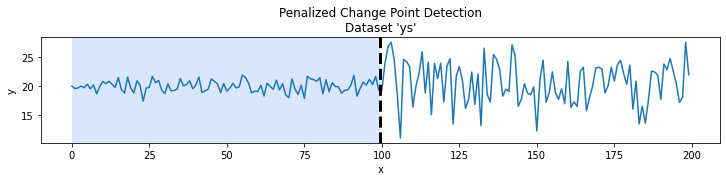

In [130]:
# detection
algo = rpt.Pelt(model="rbf").fit(ys)
result = algo.predict(pen= 5)

# display
rpt.display(ys, [100], result)
pl.title("Penalized Change Point Detection\nDataset 'ys'")
pl.xlabel("x")
pl.ylabel("y")
pl.show()

**Fig. 5.** Change point detection using the rupture package. The breakpoint is correctly placed at ~ x = 100. The code is run on the ys dataset that was randomly generated and manipulated in terms of standard deviation. The pelt method was used and pen was set = 5.

# read in the data from LANL earthquake prediction 
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [22]:
eq1 = pd.read_csv("http://fbb.space/mltsa/LALNeq.csv")
eq1.drop('Unnamed: 0', axis=1, inplace=True)
eq1.describe()

,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06
mean,4.616407e+00,8.852012e-01
std,2.614006e+01,3.374432e-01
min,-4.621000e+03,3.008971e-01
25%,2.000000e+00,5.934956e-01
50%,5.000000e+00,8.849986e-01
75%,7.000000e+00,1.177597e+00
max,3.252000e+03,1.469100e+00


In [23]:
eq1.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [18]:
eq1

,acoustic_data,time_to_failure
0,12,1.469100
1,6,1.469100
2,8,1.469100
3,5,1.469100
4,8,1.469100
...,...,...
4499995,4,0.300897
4499996,6,0.300897
4499997,1,0.300897
4499998,3,0.300897


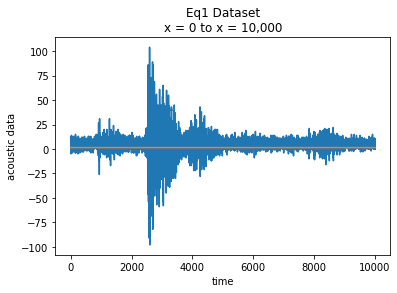

In [135]:
pl.plot(eq1[0:10000])
pl.title("Eq1 Dataset\nx = 0 to x = 10,000")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

**Fig. 6.** Plot of earthquake dataset. Only the first 10,000 data points are shown for visibility purposes. The x-axis represents time stamps, while the y-axis represents the acoustic data measure. In general, the data hovers around a baseline level at about zero. There is a large burst between approximetaly x = 2,500 and x = 3,800 that decreases slowly. Around x = 4,000, there is another smaller burst. There are some smaller spikes earlier in the time series and towards the end of the full time series.

# using rupture

Go through the documentation of rupture. 

Look at the "cost functions" and "search methos" tab here - https://centre-borelli.github.io/ruptures-docs/user-guide/ and the paper https://arxiv.org/pdf/1801.00718.pdf to find the computational cost associate to each method (Section 5).

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




Look at the "cost functions" and "search methos" tab here - https://centre-borelli.github.io/ruptures-docs/user-guide/ and the paper https://arxiv.org/pdf/1801.00718.pdf to find the computational cost associate to each method.





In [96]:
datapoints = [10000, 5000, 1000]
result1 = []

for i in range(0,3):
  algo1 = rpt.Dynp(model="rbf", jump = 100).fit(eq1[0:datapoints[i]])
  result1.append(algo1.predict(n_bkps=1))

print(f"Index of detected change point for 10,000, 5,000 and 1,000 data points respectively:\n{result1}")

Index of detected change point for 10,000, 5,000 and 1,000 data points respectively:
[[4900, 10000], [2500, 5000], [900, 1000]]


**Comment:** The dynamic programming method uses dynamic programming to minimize the sum of squared errors in order to detect points of change. The method is denoted as "Dynp". 

The cost function is chosen by the user and specified using "model". I chose "rbf" (radial distance function) here. 

The "jump" parameter is optional and decreases computation time. If jump = k, only every kth datapoint is considered for change point. I chose to set jump =100, because execution was stuck on this line for over an hour. 

The model is then fit onto the signal using the method .fit(). The user specifies the number of breakpoints they want. (This reminds me of the problem associated with deciding for a certain number of clusters in a dataset. If I want to get 100 reakpoints, the function will return 100 breakpoints, but they might not be useful.)

Finally, .predict() performs the change point detection using the algorithm specified above. It outputs a list of breakpoints (last entry is the # datapoints). 

In [52]:
result1_1 = result1[0]
result1_2 = result1[1]
result1_3 = result1[2]

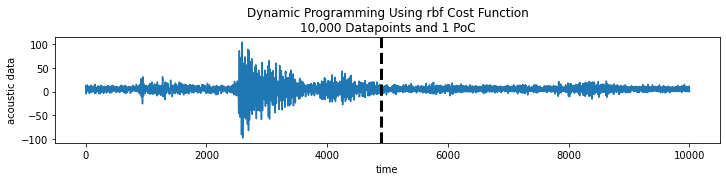

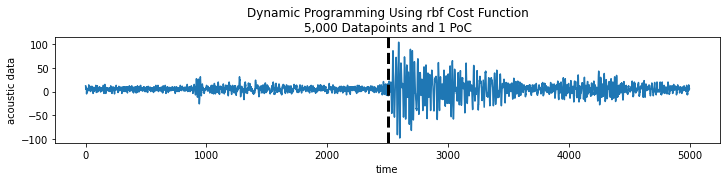

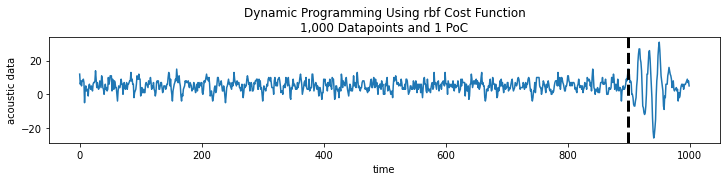

In [136]:
# N = 10,000
rpt.display(eq1.acoustic_data.values[:10000], [], result1_1)
pl.title("Dynamic Programming Using rbf Cost Function\n10,000 Datapoints and 1 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 5,000
rpt.display(eq1.acoustic_data.values[:5000], [], result1_2)
pl.title("Dynamic Programming Using rbf Cost Function\n5,000 Datapoints and 1 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 1,000
rpt.display(eq1.acoustic_data.values[:1000], [], result1_3)
pl.title("Dynamic Programming Using rbf Cost Function\n1,000 Datapoints and 1 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

**Fig. 7.** This figure shows earthquake data from Kaggle. The first subplot includes 10,000 datapoints, the second sub-plot includes the first 5,000, and the third subplot includes the first 1,000 datapoints of the dataset. 

The plots show the point of change computed by the model above for N = 10,000 , 5,000 and 1,000, respectively. 

The full dataset and the subsets detect different points of change. When n = 10,000 the PoC is at x = 4,900. For n = 5,000 and n = 1,000, the PoC is at x = 2,500 and x = 900, respectively. 

Inutituvely, it seems that subplot 2 detects the most meaningful point of change in the data series. 

In [99]:
datapoints = [10000, 5000, 1000]
result2 = []

for i in range(0,3):
  algo2 = rpt.Dynp(model="rbf", jump = 100).fit(eq1[0:datapoints[i]])
  result2.append(algo2.predict(n_bkps=2))

print(f"Indices of two detected change points for 10,000, 5,000 and 1,000 data points respectively:\n{result2}")

Indices of two detected change points for 10,000, 5,000 and 1,000 data points respectively:
[[2500, 4800, 10000], [2500, 3500, 5000], [300, 900, 1000]]


**Comment:** Same procedure and parameter choices like above. The difference is the number of change points. Here, I'm requesting 2 points of change (bkps = 2).

In [46]:
result2_1 = result2[0]
result2_2 = result2[1]
result2_3 = result2[2]

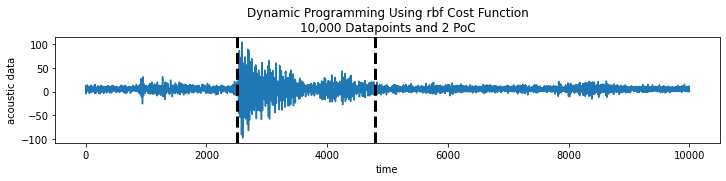

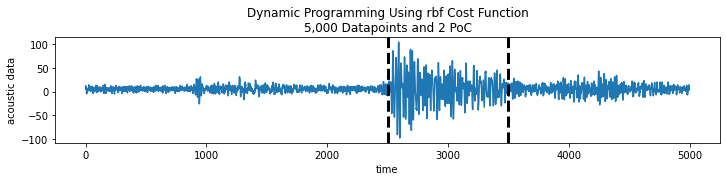

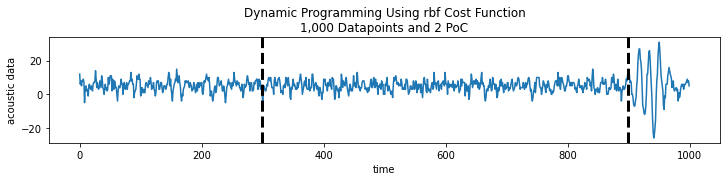

In [137]:
# N = 10,000
rpt.display(eq1.acoustic_data.values[:10000], [], result2_1)
pl.title("Dynamic Programming Using rbf Cost Function\n10,000 Datapoints and 2 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 5,000
rpt.display(eq1.acoustic_data.values[:5000], [], result2_2)
pl.title("Dynamic Programming Using rbf Cost Function\n5,000 Datapoints and 2 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 1,000
rpt.display(eq1.acoustic_data.values[:1000], [], result2_3)
pl.title("Dynamic Programming Using rbf Cost Function\n1,000 Datapoints and 2 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

**Fig.8.** The plots show the two points of change computed by the model above for N = 10,000 , 5,000 and 1,000, respectively. The data is the same Kaggle data. 

The full dataset and the subsets detect different points of change. When n = 10,000 the PoCs are located at x = 2,500 and x = 4,800. For n = 5,000 and n = 1,000, the PoCs are at x = 2,500 and x = 3,500, and at x = 300 and x = 900, respectively.

It now seems that the breakpoints associated with the first two subplots enclose a critical chunk of the time series. The first one is larger, including both the large and the susequent smaller burst, while the second one isolates the large burst.

In [101]:
datapoints = [10000, 5000, 1000]
result3 = []

for i in range(0,3):
  algo3 = rpt.Dynp(model="rbf", jump = 100).fit(eq1[0:datapoints[i]])
  result3.append(algo3.predict(n_bkps=3))

print(f"Indices of three detected change points for 10,000, 5,000 and 1,000 data points respectively:\n{result3}")

Indices of three detected change points for 10,000, 5,000 and 1,000 data points respectively:
[[2500, 3500, 4800, 10000], [2500, 3400, 4500, 5000], [100, 300, 900, 1000]]


**Comment:** Same procedure and parameter choices like above. The difference is the number of change points. Here, I'm requesting 3 points of change (bkps = 3).

In [49]:
result3_1 = result3[0]
result3_2 = result3[1]
result3_3 = result3[2]

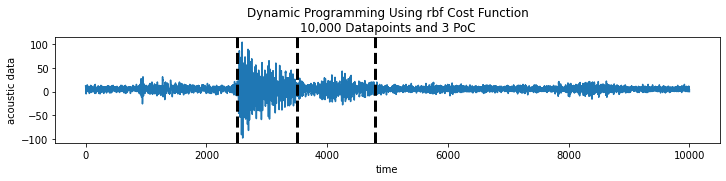

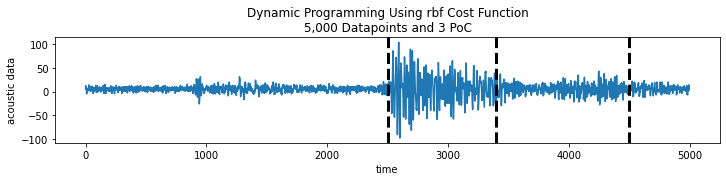

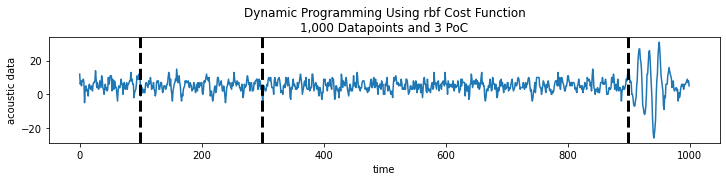

In [139]:
# N = 10,000
rpt.display(eq1.acoustic_data.values[:10000], [], result3_1)
pl.title("Dynamic Programming Using rbf Cost Function\n10,000 Datapoints and 3 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 5,000
rpt.display(eq1.acoustic_data.values[:5000], [], result3_2)
pl.title("Dynamic Programming Using rbf Cost Function\n5,000 Datapoints and 3 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

# N = 1,000
rpt.display(eq1.acoustic_data.values[:1000], [], result3_3)
pl.title("Dynamic Programming Using rbf Cost Function\n1,000 Datapoints and 3 PoC")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show()

**Fig. 9.** The plots show the three points of change computed by the model above for N = 10,000 , 5,000 and 1,000, respectively. The data is the same Kaggle data.

The full dataset and the subsets detect different points of change. When n = 10,000 the PoCs are at x = 2,500, x = 3,500 and x = 4,800. For n = 5,000 and n = 1,000, the PoCs are at x = 2,500, x = 3,400, x = 4,500, and at x = 100, x = 300, x = 900 respectively.

It now seems that the breakpoints associated with the first two subplots enclose the same two critical chunks of the time series: the large burst and the smaller burst. The shortest sub-set in subplot 3 detects the onset of some spikes early in the time series. 

Find a method that has computational complexity O(Nlog(N))

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

In [141]:
# dynamic programming (n^2 complexity) 
algo = rpt.Dynp(model="rbf", jump = 100).fit(eq1[0:10000])
result = algo.predict(n_bkps=6)

print(result)

[900, 2500, 3500, 4800, 8000, 8700, 10000]


**Comment:** Like above, I'm using Dynp as a method of complexity of order O(kN^2). I now request 6 breakpoints to obtain three chunks (enclosed by these breakpoints).  

In [142]:
# binary segmentation (log complexity)
algo_bin = rpt.Binseg(model="rbf", jump = 100).fit(eq1[0:10000])
result_bin = algo_bin.predict(n_bkps=6)

print(result_bin)

[900, 1700, 2500, 3500, 4900, 9000, 10000]


**Comment:** Methods with computational complexity of order O(Nlog(N)) are segmentation methods. Here, I decided to go with binary segmentation. Binary segmentations first detects a single PoC and then splits the data series into two sub-series at that point. Further breakpoints are identified by repeating this procedure on the resulting sub-series.  The opposite occurs in bottom-up segmenting, where first many PoC are defined and then gradually deleted. 

The code is similar to the code used above. However, I now specify the method Binseg rather than Dynp. I use the same cost function (rbf) as before, as well as the same data and jump = 100. I also compute 6 breakpoints to obtain three chunks. 

Binseg is much faster than Dynp. As promised in the documentation, the execution takes a lot less time to complete. 

The locations of breakpoint are similar to the ones detected by Dynp. However, here we have an extra Poc at x = 1,700, while lacking one later in the time series x = 8,000. This must be due to the segmentation procedure, where sub-series are defined based on a single PoC. A symmetric picture must emerge. 

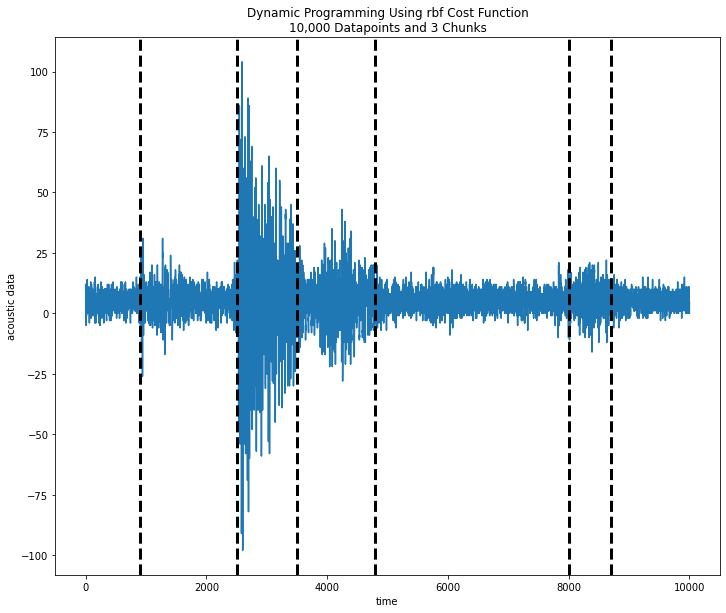

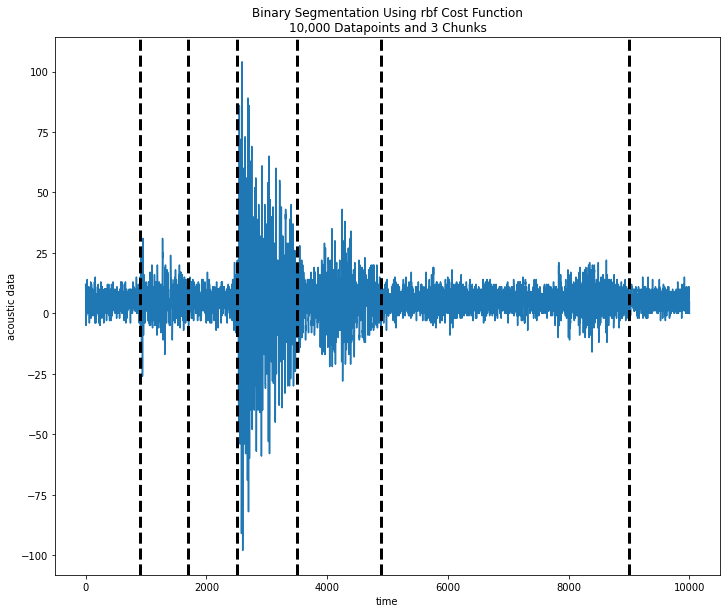

In [143]:
rpt.display(eq1.acoustic_data.values[:10000],[], result, figsize = (10,8))
pl.title("Dynamic Programming Using rbf Cost Function\n10,000 Datapoints and 3 Chunks")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show

rpt.display(eq1.acoustic_data.values[:10000],[], result_bin, figsize = (10,8))
pl.title("Binary Segmentation Using rbf Cost Function\n10,000 Datapoints and 3 Chunks")
pl.xlabel("time")
pl.ylabel("acoustic data")
pl.show;

**Fig. 10.** The plots show six points of change computed by dynamic programming (subplot 1) and binary segmentations (subplot 2). The three critical chunks of the time series seems to be the following:


Chunk 1: x = 2,500 through x = 3,500 (large burst)

Chunk 2: x = 3,500 through x = 4,900 (small burst) 

Chunk 3: x = 900 through x = 1,700 (initial spikes)

*OR*

Chunk 3: x = 8,000 through x = 8,700 (later spikes)

Both Dynamic programming and binary segmentation detect the small and the large bursts, which seem to be the most notable characteristics of the time series. However, only dynamic programming detects the later spikes, while only binary segmentation detects the intitial spikes as a critical chunk. This highlights differences in the underlying computation mechanisms. 

The indices associated with each method are printed above. 